In [1]:
## Dependencies
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from patchify import patchify, unpatchify
from skimage.io import imread

from sewar.full_ref import ssim, msssim, mse
from tqdm.notebook import tqdm
import ray
import webbrowser

# local
from NanTex_backend.Util.pyDialogue import pyDialogue as pD

In [2]:
def extract_files_from_dir(dir_path: str, file_type: str) -> dict:
    if file_type in ["jpg", "png", "jpeg"]:
        # grab all files in the directory
        files_original = glob(f"{dir_path}/feature_?*.{file_type}")
        files_dream = glob(f"{dir_path}/original_feature*.{file_type}")

        # load the images
        original_images = [imread(file) for file in files_original]
        dream_images = [imread(file) for file in files_dream]
        return {"original": original_images, "dream": dream_images}
    elif file_type == "npy":
        # grab all files in the directory
        files_original = glob(f"{dir_path}/feature_?*.npy")
        files_dream = glob(f"{dir_path}/original_feature*.npy")

        # load the images
        original_images = [np.load(file) for file in files_original]
        dream_images = [np.load(file) for file in files_dream]
        return {"original": original_images, "dream": dream_images}

In [3]:
# grab data
directories: list = pD.askDIRS()  ## just choose the partent directory where all dream folders containing the images are
files: dict = {
    dir_path.split("\\")[-1]: extract_files_from_dir(dir_path, "npy")
    for dir_path in directories
}

## Global Eval

In [4]:
# global evaluation
# currently, we will only caclulate SSIM, MSSSIM and MSE


@ray.remote
def global_eval(in_tuple: tuple) -> dict:
    # unpack
    dream_key, dream = in_tuple
    # out
    out = {}
    # pass the images through the evaluation
    for feature_index in range(len(dream["original"])):
        out[f"feature_{feature_index}"] = {}
        # calculate the evaluation
        for eval in [mse, ssim, msssim]:
            out[f"feature_{feature_index}"][eval.__name__] = eval(
                dream["original"][feature_index], dream["dream"][feature_index]
            )
            # cleanup
            if eval.__name__ == "ssim":
                out[f"feature_{feature_index}"][eval.__name__] = out[
                    f"feature_{feature_index}"
                ][eval.__name__][0]
            if eval.__name__ == "msssim":
                out[f"feature_{feature_index}"][eval.__name__] = np.real(
                    out[f"feature_{feature_index}"][eval.__name__]
                )
    dream["global_eval"] = out
    return dream_key, dream

In [5]:
# spinup ray instance
context = ray.init(
    num_cpus=12,  # <-------- change this to the number of cpus you have
    num_gpus=0,  # leave this as 0
    ignore_reinit_error=True,
)
# automatically open the ray dashboard
ray_dashboard_url = f"http://{context.address_info['webui_url']}"
webbrowser.open(ray_dashboard_url, new=2, autoraise=True)

In [6]:
# offload the evaluation to the ray instance
file_pointers: list = [ray.put((key, files[key])) for key in files.keys()]
state_pointers: list = [global_eval.remote(pointer) for pointer in file_pointers]

finished_global_states = []

# loop through the directories
with tqdm(total=len(state_pointers)) as pbar:
    while len(state_pointers) > 0:
        try:
            finished, state_pointers = ray.wait(state_pointers, timeout=8.0)
            data = ray.get(finished)
            finished_global_states.extend(data)
            pbar.n = len(finished_global_states)
            pbar.refresh()
        except KeyboardInterrupt:
            break

In [7]:
# reconstruct the complete dictionary
files = {key: value for key, value in finished_global_states}

# extract the global evaluation
global_eval_dict = {key: value["global_eval"] for key, value in finished_global_states}
global_eval_dict["average"] = {
    feature_key: {
        eval_key: np.mean(
            [value[feature_key][eval_key] for value in global_eval_dict.values()]
        )
        for eval_key in global_eval_dict["dream_0"]["feature_0"].keys()
    }
    for feature_key in global_eval_dict["dream_0"].keys()
}
global_eval_dict["average"]

In [43]:
ray.shutdown()

## Local Eval

In [33]:
# patchify and linearize
def patchify_and_linearize(image: np.ndarray, patch_size: tuple) -> np.ndarray:
    out = patchify(image, patch_size, step=patch_size[1]).reshape(
        -1, patch_size[0], patch_size[1]
    )
    return out


def unpatchify_from_linear(
    patch_array: np.ndarray, img_size: tuple, patch_size: tuple
) -> np.ndarray:
    out = unpatchify(
        patch_array.reshape(
            np.sqrt(patch_array.shape[0]).astype(int),
            np.sqrt(patch_array.shape[0]).astype(int),
            patch_size[0],
            patch_size[1],
        ),
        img_size,
    )
    return out

In [34]:
## Ray worker for local evaluation
@ray.remote
def local_eval(in_tuple: tuple) -> float:
    # unpack
    dream_key, dream = in_tuple
    # out
    out = {}
    # pass each patch pair through the eval
    for feature_index in range(len(dream["original"])):
        # patchify and linearize
        dream_linear = patchify_and_linearize(
            dream["dream"][feature_index], (64, 64)
        )  # <--- change this to set the patch size
        original_linear = patchify_and_linearize(
            dream["original"][feature_index], (64, 64)
        )  # <--- change this to set the patch size
        # create contaienr
        patch_out = {}
        # pass through eval
        for patch_index in range(dream_linear.shape[0]):
            metric_out = {}
            for eval in [mse, ssim, msssim]:
                current_out = eval(
                    GT=original_linear[patch_index], P=dream_linear[patch_index]
                )

                # cleanup
                if eval.__name__ == "ssim":
                    current_out = current_out[0]
                if eval.__name__ == "msssim":
                    current_out = np.real(current_out)

                # reassemble
                metric_out[eval.__name__] = current_out
            patch_out[f"patch_{patch_index}"] = metric_out
        out[f"feature_{feature_index}"] = patch_out
    dream["local_eval"] = out

    return dream_key, dream

In [35]:
# spinup ray instance
context = ray.init(
    num_cpus=12,  # <-------- change this to the number of cpus you have
    num_gpus=0,  # leave this as 0
    ignore_reinit_error=True,
)
# automatically open the ray dashboard
ray_dashboard_url = f"http://{context.address_info['webui_url']}"
webbrowser.open(ray_dashboard_url, new=2, autoraise=True)

In [36]:
# offload the evaluation to the ray instance
file_pointers: list = [ray.put((key, files[key])) for key in files.keys()]
state_pointers: list = [local_eval.remote(pointer) for pointer in file_pointers]

finished_local_states = []

# loop through the directories
with tqdm(total=len(state_pointers)) as pbar:
    while len(state_pointers) > 0:
        try:
            finished, state_pointers = ray.wait(state_pointers, timeout=8.0)
            data = ray.get(finished)
            finished_local_states.extend(data)
            pbar.n = len(finished_local_states)
            pbar.refresh()
        except KeyboardInterrupt:
            break

In [37]:
# reconstruct the complete dictionary
files = {key: value for key, value in finished_local_states}

# extract the global evaluation
local_eval_dict = {key: value["local_eval"] for key, value in finished_local_states}

In [38]:
## Generate Colored Overlays for the Local Evaluation to be used in figures
def create_patched_overlays(
    local_eval: np.ndarray, patch_size: tuple, img_size: tuple
) -> np.ndarray:
    # create overlay mask
    overlay_mask = np.ones(patch_size)
    # metrics
    metric_keys = list(local_eval["feature_0"]["patch_0"].keys())
    # scale with local eval
    overlay = {
        feature_key: {
            metric_key: unpatchify_from_linear(
                np.stack(
                    [
                        overlay_mask * local_eval[feature_key][patch_key][metric_key]
                        for patch_key in local_eval[feature_key].keys()
                    ],
                    axis=0,
                ),
                img_size,
                patch_size,
            )
            for metric_key in metric_keys
        }
        for feature_key in local_eval.keys()
    }

    return overlay


overlay_dict = {
    dream_key: create_patched_overlays(
        local_eval_dict[dream_key],
        (64, 64),  # <--- change this to set the patch size
        files[dream_key]["dream"][0].shape,
    )
    for dream_key in files.keys()
}

In [39]:
## Plot Overlays

dream_key: str = "dream_0"
metric_key: str = "ssim"

fig, axs = plt.subplots(2, len(files[dream_key]["dream"]), figsize=(10, 10), dpi=150)
# plot original and dream with colorful overlay

# original
for i, original in enumerate(files[dream_key]["original"]):
    axs[0, i].imshow(original, cmap="gray")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Original {i}")

# dream
for i, dream in enumerate(files[dream_key]["dream"]):
    axs[1, i].imshow(dream, cmap="gray")
    img = axs[1, i].imshow(
        overlay_dict[dream_key][f"feature_{i}"][metric_key],
        cmap="jet",
        alpha=0.2,
        vmin=0,
        vmax=1,
    )
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Dream {i}")

# add horizontal colorbar at the bottom
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title(metric_key)

## Sanity Check - Repeat original quantification

In [1]:
from NanTex_backend.Util.pyDialogue import pyDialogue as pD
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Union
import torch

In [2]:
from torcheval.metrics import PeakSignalNoiseRatio
from pytorch_msssim import ssim, SSIM, MS_SSIM

In [17]:
# grab data
filepaths: List[str] = (
    pD.askFILES()
)  ## just choose the partent directory where all dream folders containing the images are
files: Dict[str, np.ndarray] = {
    os.path.basename(file_path)[:-4]: np.load(file_path)
    for file_path in tqdm(filepaths)
    if file_path.endswith(".npy")
}

  0%|          | 0/480 [00:00<?, ?it/s]

In [18]:
files["ImMIX_POST_ER-MIC-CLT_(0,0,0_(0,0)_max(560.0))"].shape

(3840, 3840, 6)

In [65]:
ft_files = pD.askFILES()  ## just choose the partent directory where all dream folders containing the images are
gt_files = pD.askFILES()  ## just choose the partent directory where all dream folders containing the images are

ft_files = {
    os.path.basename(file_path)[:-4]: imread(file_path)
    for file_path in ft_files
    if file_path.endswith((".jpg", ".png", ".jpeg"))
}
gt_files = {
    os.path.basename(file_path)[:-4]: imread(file_path)
    for file_path in gt_files
    if file_path.endswith((".jpg", ".png", ".jpeg"))
}

# numpy and stack
files = {
    "patch": np.stack(
        [file for file in list(ft_files.values()) + list(gt_files.values())], axis=2
    )
}

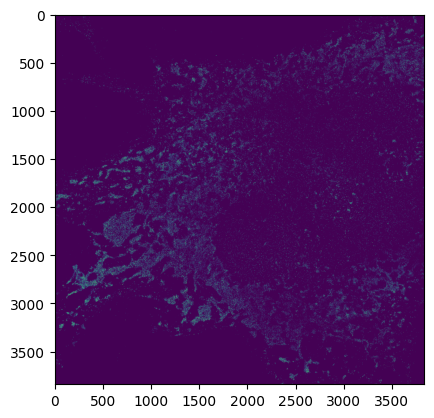

In [21]:
plt.imshow(files["ImMIX_POST_ER-MIC-CLT_(0,0,0_(0,0)_max(560.0))"][..., 0])

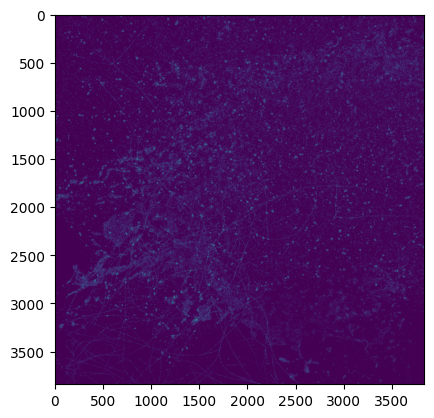

In [19]:
plt.imshow(
    np.sum(files["ImMIX_POST_ER-MIC-CLT_(0,0,0_(0,0)_max(560.0))"][..., :3], axis=2)
)

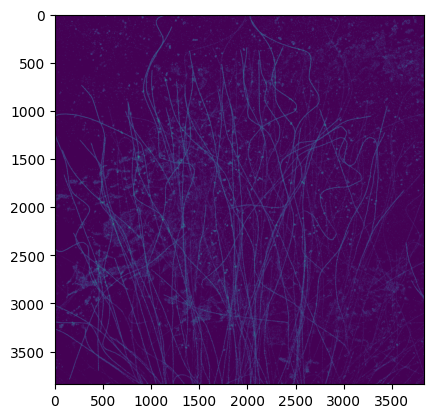

In [38]:
plt.imshow(
    np.sum(files["ImMIX_POST_ER-MIC-CLT_(0,4,1_(1,0)_max(630.0))"][..., :3], axis=2)
)

In [22]:
# rearrange
files = {
    k: np.stack(
        [a[..., 3], a[..., 4], a[..., 5], a[..., 0], a[..., 1], a[..., 2]], axis=2
    )
    for k, a in files.items()
}

In [23]:
## eval torch
def eval_torch(
    file: np.ndarray,
    num_features: int,
    metrics: List[callable],
    return_name: bool,
    file_name: str = None,
    device: str = "cpu",
) -> Union[Tuple[str, Dict[str, Dict[str, float]]], Dict[str, Dict[str, float]]]:
    ## PART 0: SETUP
    results: Dict[str, Dict[str, float]] = {
        f"feature_{i}": {} for i in range(num_features)
    }

    ## PART 1: PREPROCESSING
    # format tensor and move to device

    # in_file = np.stack([file[i,...] for i in range(file.shape[0]) if i not in [num_features, 2*num_features +1]], axis = 2) # the input file has sequence(pred, pred overlay, gt, gt overlay)
    in_file = np.expand_dims(file, axis=0)  # add batch dimension
    in_file = np.expand_dims(in_file, axis=0)  # add channel dimension
    in_file = torch.Tensor(in_file).to(device)

    ## PART 2: EVALUATION
    with torch.no_grad():
        for i in range(num_features):
            in_data = in_file[..., i]
            target_data = in_file[..., i + num_features]
            for metric in metrics:
                if "update" in dir(metric):
                    metric.update(in_data, target_data)
                    metric_result = metric.compute()
                else:
                    metric_result = metric(in_data, target_data)
                # append to results
                results[f"feature_{i}"][metric.__class__.__name__] = (
                    metric_result.cpu().detach().numpy()
                    if isinstance(metric_result, torch.Tensor)
                    else metric_result
                )

    ## PART 3: RETURN
    if return_name:
        return file_name, results
    return results


def retrieve_metrics(
    results: Dict[str, Dict[str, Dict[str, float]]],
    file_name: str,
    feature: str,
    metric: str,
) -> float:
    try:
        return results[file_name][feature][metric]
    except KeyError:
        return np.nan


def fetch_results_from_device(
    results: Dict[str, Dict[str, Dict[str, float]]], device: str
) -> Dict[str, Dict[str, Dict[str, float]]]:
    fetched_results = {}
    for file_name, file_results in results.items():
        fetched_results[file_name] = {}
        for feature, feature_results in file_results.items():
            fetched_results[file_name][feature] = {}
            for metric, value in feature_results.items():
                if isinstance(value, torch.Tensor):
                    fetched_results[file_name][feature][metric] = (
                        value.cpu().detach().numpy()
                    )
                else:
                    fetched_results[file_name][feature][metric] = value
    return fetched_results


def average_results_per_metric(
    results: Dict[str, Dict[str, Dict[str, float]]], metric: str
) -> float:
    values = []
    for _, file_results in results.items():
        for feature_results in file_results.values():
            if metric in feature_results:
                values.append(feature_results[metric])
    return np.mean(values) if values else np.nan


def average_all_results_per_feature(
    results: Dict[str, Dict[str, Dict[str, float]]],
) -> Dict[str, Dict[str, float]]:
    averages = {}
    for _, file_results in results.items():
        for feature, feature_results in file_results.items():
            if feature not in averages:
                averages[feature] = {}
            for metric, value in feature_results.items():
                if metric not in averages[feature]:
                    averages[feature][metric] = []
                averages[feature][metric].append(value)
    # Compute the mean for each metric
    for feature, metrics in averages.items():
        for metric, values in metrics.items():
            metrics[metric] = np.mean(values) if values else np.nan
    return averages


def average_all_results(
    results: Dict[str, Dict[str, Dict[str, float]]],
) -> Dict[str, float]:
    averages = {}
    for metric in results[next(iter(results))][
        next(iter(results[next(iter(results))]))
    ].keys():
        averages[metric] = average_results_per_metric(results, metric)
    return averages

In [5]:
files["current_dream"] = np.stack(
    [
        files["current_dream"][i, ...]
        for i in range(files["current_dream"].shape[0])
        if i not in [3, 7]
    ],
    axis=2,
)
files["legacy_dream"] = np.stack(
    [
        files["legacy_dream"][i, ...]
        for i in range(files["legacy_dream"].shape[0])
        if i not in [3, 7]
    ],
    axis=2,
)
files["fever_dream"] = np.stack(
    [
        files["fever_dream"][i, ...]
        for i in range(files["fever_dream"].shape[0])
        if i not in [3, 7]
    ],
    axis=2,
)

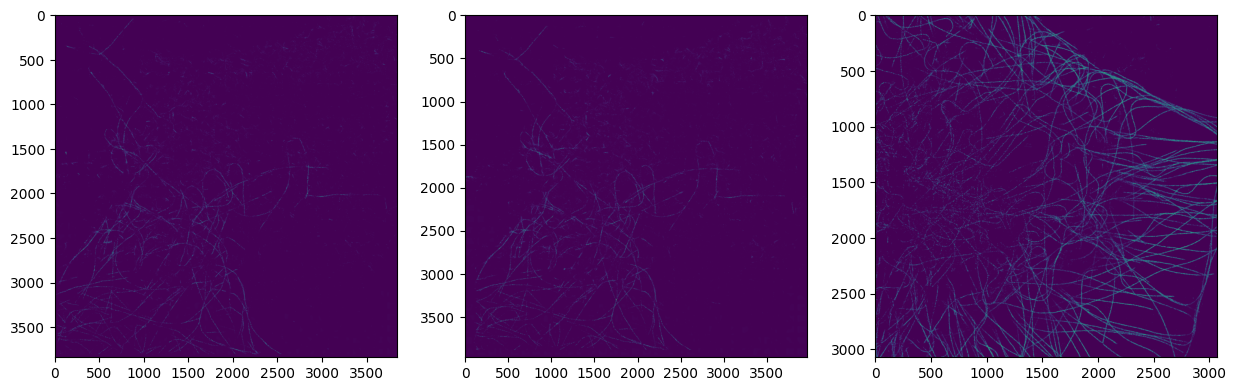

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(files["current_dream"][..., 1])
axs[1].imshow(files["legacy_dream"][..., 1])
axs[2].imshow(files["fever_dream"][..., 1])

In [24]:
## bulk
# prep
num_features = 3
metrics = [
    PeakSignalNoiseRatio(data_range=255.00),
    SSIM(data_range=255, size_average=False, channel=1, nonnegative_ssim=True),
    MS_SSIM(data_range=255, size_average=False, channel=1),
]

# cast metrics to device
device = "cuda" if torch.cuda.is_available() else "cpu"
# move metrics to device
metrics = [metric.to(device) for metric in metrics]

# execution
total_results: Dict[str, Dict[str, Dict[str, float]]] = {
    file_name: eval_torch(
        file,
        num_features,
        metrics,
        return_name=False,
        file_name=file_name,
        device=device,
    )
    for file_name, file in tqdm(files.items(), total=len(files))
}

  0%|          | 0/480 [00:00<?, ?it/s]

In [26]:
from pprint import pprint

# gregors dream 15.08.2025
pprint(average_all_results_per_feature(total_results))

{'feature_0': {'MS_SSIM': 0.8167946,
               'PeakSignalNoiseRatio': 24.394215,
               'SSIM': 0.7638205},
 'feature_1': {'MS_SSIM': 0.9033577,
               'PeakSignalNoiseRatio': 24.4021,
               'SSIM': 0.84320295},
 'feature_2': {'MS_SSIM': 0.8330229,
               'PeakSignalNoiseRatio': 24.400244,
               'SSIM': 0.7927422}}


In [69]:
## WU img
pprint(total_results)

{'patch': {'feature_0': {'MS_SSIM': array(0.8458469, dtype=float32),
                         'PeakSignalNoiseRatio': array(23.137917, dtype=float32),
                         'SSIM': array(0.74715257, dtype=float32)},
           'feature_1': {'MS_SSIM': array(0.9406191, dtype=float32),
                         'PeakSignalNoiseRatio': array(23.895775, dtype=float32),
                         'SSIM': array(0.8206966, dtype=float32)},
           'feature_2': {'MS_SSIM': array(0.77433944, dtype=float32),
                         'PeakSignalNoiseRatio': array(24.187605, dtype=float32),
                         'SSIM': array(0.66460824, dtype=float32)}}}


# PSNR
https://stackoverflow.com/questions/20663688/typical-psnr-values

If your pixels are represented using 8 bits per sample, the maximum possible pixel value of the image is 255. 20*log10(255) = 48 dB the mean squared error (MSE) of noise is not considered yet. The typical compression ratio of jpeg is no less than 7. In that case the MSE is around 0.224, and the corresponding PSNR is 54 dB. So you probably will not get the PSNR as high as 63 dB.

In [86]:
normalize(files["patch"][..., 0]).shape

(512, 512)

In [138]:
from sklearn.metrics import mean_squared_error


def normalize(tensor: torch.Tensor) -> torch.Tensor:
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())


def denormalize(tensor: torch.Tensor, min_val: float, max_val: float) -> torch.Tensor:
    return tensor * (max_val - min_val) + min_val


def standardize(tensor: torch.Tensor) -> torch.Tensor:
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / (std + 1e-5)


mse = mean_squared_error(
    normalize(files["patch"][..., 0]), normalize(files["patch"][..., 3])
)

In [139]:
mse

0.004803949769847218

In [131]:
normalize(files["patch"][..., 3]).max()

1.0

In [140]:
20 * np.log10(255.0) - 10 * np.log10(mse)

71.31481903101285

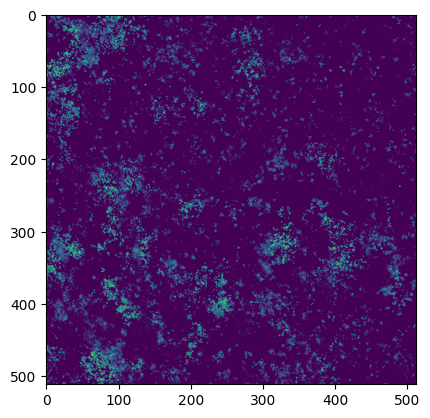

In [110]:
plt.imshow(files["patch"][..., 0])

In [96]:
files["patch"][..., 5].max()

251

In [76]:
files["patch"][..., 0] - files["patch"][..., 3]

array([[  0,  38,  43, ...,   0,   0,   0],
       [ 41,  29,   0, ...,   0,   0,   0],
       [ 35,   0,   0, ...,   0,   0,   0],
       ...,
       [  1, 251,  16, ...,   0,   0,   0],
       [  1,   9,   0, ...,   0,   0,   0],
       [238,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [75]:
20 * np.log10(255) - 10 * np.log10(5)

41.141103565318915

In [61]:
# WU patch from WU img
pprint(total_results)

{'patch': {'feature_0': {'MS_SSIM': array(0.8458469, dtype=float32),
                         'PeakSignalNoiseRatio': array(23.137917, dtype=float32),
                         'SSIM': array(0.74715257, dtype=float32)},
           'feature_1': {'MS_SSIM': array(0.9406191, dtype=float32),
                         'PeakSignalNoiseRatio': array(23.895775, dtype=float32),
                         'SSIM': array(0.8206966, dtype=float32)},
           'feature_2': {'MS_SSIM': array(0.77433944, dtype=float32),
                         'PeakSignalNoiseRatio': array(24.187605, dtype=float32),
                         'SSIM': array(0.66460824, dtype=float32)}}}


In [39]:
average_results_per_metric(total_results, metric="MS_SSIM")

0.85469806

In [40]:
from pprint import pprint

In [8]:
# gregors dream 15.08.2025
pprint(average_all_results_per_feature(total_results))

{'feature_0': {'MS_SSIM': 0.67452693,
               'PeakSignalNoiseRatio': 20.577179,
               'SSIM': 0.65495825},
 'feature_1': {'MS_SSIM': 0.76461756,
               'PeakSignalNoiseRatio': 20.570812,
               'SSIM': 0.6928685},
 'feature_2': {'MS_SSIM': 0.77177244,
               'PeakSignalNoiseRatio': 20.63881,
               'SSIM': 0.7812437}}


In [ ]:
# würzburg 15.08.2025
pprint(average_all_results_per_feature(total_results))

{'feature_0': {'MS_SSIM': 0.82227194,
               'PeakSignalNoiseRatio': 24.69927,
               'SSIM': 0.8205853},
 'feature_1': {'MS_SSIM': 0.9088851,
               'PeakSignalNoiseRatio': 24.702394,
               'SSIM': 0.8705131},
 'feature_2': {'MS_SSIM': 0.83293736,
               'PeakSignalNoiseRatio': 24.701551,
               'SSIM': 0.80520743}}


In [41]:
average_all_results(total_results)

{'PeakSignalNoiseRatio': 24.701073, 'SSIM': 0.8321019, 'MS_SSIM': 0.85469806}